In [3]:
import tensorflow as tf
import numpy as np
import keras

D1019 14:46:15.689236210  133439 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1019 14:46:15.689261631  133439 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1019 14:46:15.689265345  133439 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1019 14:46:15.689268277  133439 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1019 14:46:15.689270890  133439 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1019 14:46:15.689273472  133439 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1019 14:46:15.689276111  133439 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1019 14:46:15.

In [4]:

# Define the paths to your custom dataset
train_data_dir = "/kaggle/input/anerbc2-classification-images/Classification_images_AneRBC-II/train"
validation_data_dir = "/kaggle/input/anerbc2-classification-images/Classification_images_AneRBC-II/val"
test_data_dir = "/kaggle/input/anerbc2-classification-images/Classification_images_AneRBC-II/test"

# You can use TensorFlow's `tf.keras.utils.image_dataset_from_directory` to load your dataset.
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="binary",  # Change this to "binary" or "int" if needed.
    image_size=(256, 256),  # Adjust image size as per your model's requirements.
    batch_size=32,  # Adjust batch size as needed.
    validation_split=0.1,  # 10% of the data will be used for validation.
    subset="training",
    seed=1337,  # You can change this for reproducibility.
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="binary",  # Change this to "binary" or "int" if needed.
    image_size=(256, 256),  # Adjust image size as per your model's requirements.
    batch_size=32,  # Adjust batch size as needed.
    validation_split=0.1,  # 10% of the data will be used for validation.
    subset="validation",
    seed=1337,  # You can change this for reproducibility.
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="binary",  # Change this to "binary" or "int" if needed.
    image_size=(256, 256),  # Adjust image size as per your model's requirements.
    batch_size=32,  # Adjust batch size as needed.
)

# Print the number of samples in each dataset
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


Found 10000 files belonging to 2 classes.
Using 9000 files for training.
Found 10000 files belonging to 2 classes.
Using 1000 files for validation.
Found 1000 files belonging to 2 classes.
Number of training samples: 282
Number of validation samples: 32
Number of test samples: 32


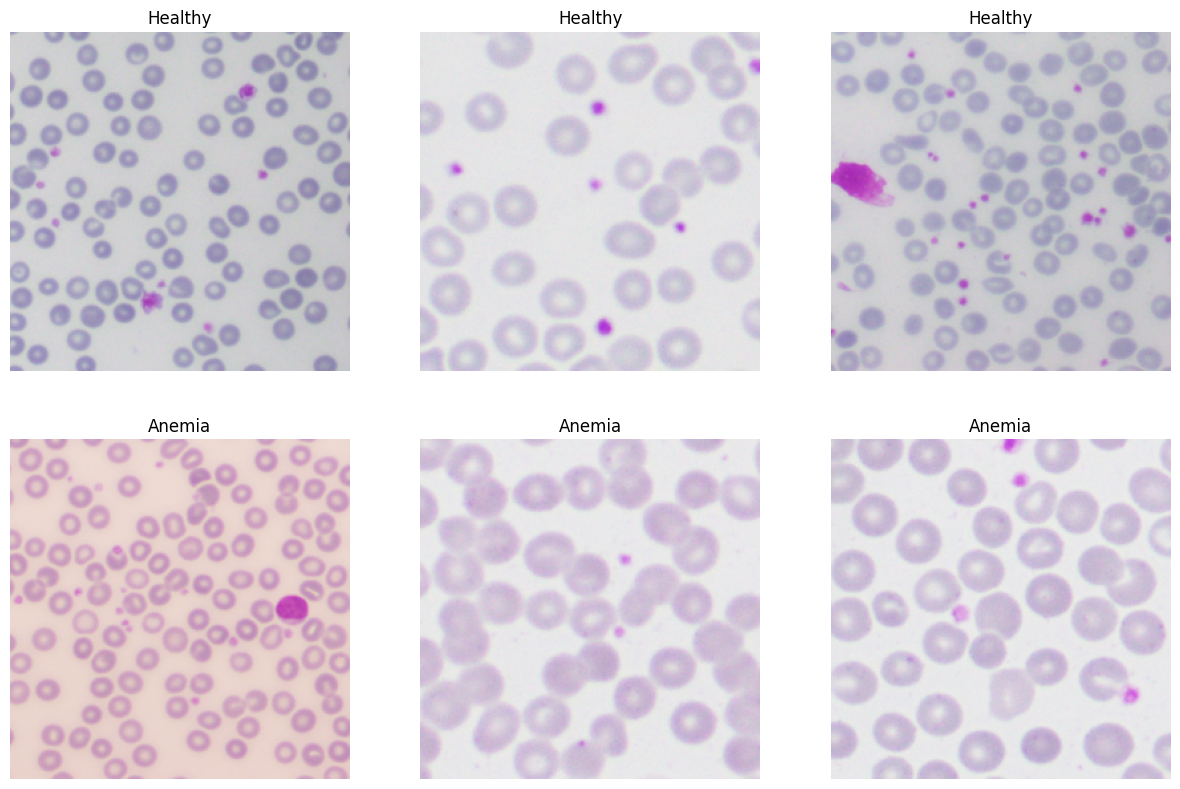

In [5]:
import matplotlib.pyplot as plt

# Assuming you want to display 9 images from the training set
num_images_to_display = 6

# Create a batch of images and labels from your custom dataset
for images, labels in train_ds.take(1):  # Take one batch of images and labels
    plt.figure(figsize=(15, 15))
    for i in range(num_images_to_display):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the i-th image in the batch
        label = labels[i].numpy()
        class_name = "Anemia" if label[0] == 1 else "Healthy"
        plt.title(class_name)
        plt.axis("off")

plt.show()


In [6]:
batch_size = 32

# Cache, batch, and prefetch your custom dataset
train_ds = train_ds.cache()
#train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=10)

validation_ds = validation_ds.cache()
#validation_ds = validation_ds.batch(batch_size)
validation_ds = validation_ds.prefetch(buffer_size=10)

test_ds = test_ds.cache()
#test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=10)


In [5]:
base_model = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(256, 256, 3))

# For ResNet152V2, input preprocessing is different from Xception.
# ResNet152V2 expects pixel values to be in the range [0, 255], so no need for additional rescaling.
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable p

In [6]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    base_model = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
    )
    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(256, 256, 3))

    # For ResNet152V2, input preprocessing is different from Xception.
    # ResNet152V2 expects pixel values to be in the range [0, 255], so no need for additional rescaling.
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    model.summary()




INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_____________________________________________

In [7]:
epochs = 300
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/300


2023-10-19 14:03:40.383877: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-10-19 14:03:40.500835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


282/282 [==============================] - ETA: 0s - loss: 0.8186 - binary_accuracy: 0.6297

2023-10-19 14:04:01.127966: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-19 14:04:01.230179: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


282/282 [==============================] - 35s 92ms/step - loss: 0.8186 - binary_accuracy: 0.6297 - val_loss: 0.5006 - val_binary_accuracy: 0.7340
Epoch 2/300
282/282 [==============================] - 7s 27ms/step - loss: 0.5227 - binary_accuracy: 0.7276 - val_loss: 0.4666 - val_binary_accuracy: 0.7600
Epoch 3/300
282/282 [==============================] - 7s 26ms/step - loss: 0.4771 - binary_accuracy: 0.7538 - val_loss: 0.4501 - val_binary_accuracy: 0.7730
Epoch 4/300
282/282 [==============================] - 7s 26ms/step - loss: 0.4590 - binary_accuracy: 0.7592 - val_loss: 0.4412 - val_binary_accuracy: 0.7730
Epoch 5/300
282/282 [==============================] - 7s 25ms/step - loss: 0.4509 - binary_accuracy: 0.7638 - val_loss: 0.4348 - val_binary_accuracy: 0.7880
Epoch 6/300
282/282 [==============================] - 7s 26ms/step - loss: 0.4471 - binary_accuracy: 0.7669 - val_loss: 0.4354 - val_binary_accuracy: 0.7570
Epoch 7/300
282/282 [==============================] - 7s 26ms/

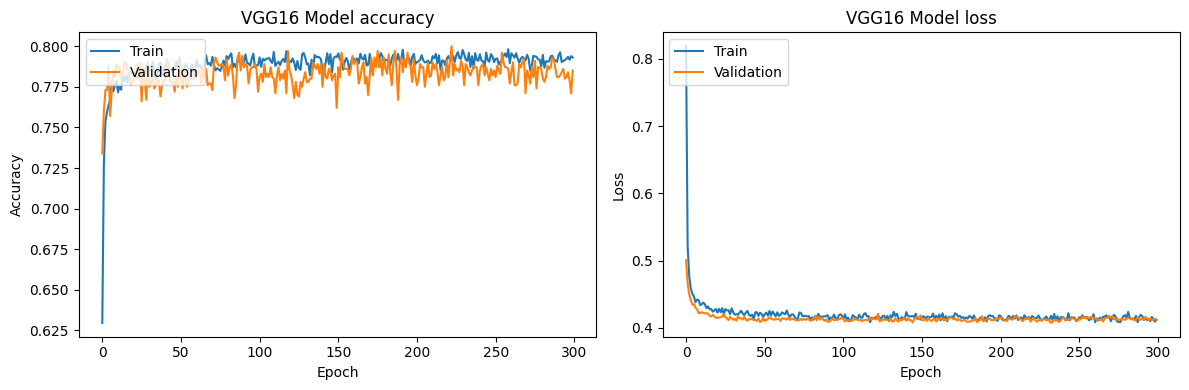

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('VGG16 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

# Define the file path where you want to save the plot
save_dir = "/kaggle/working/"
file_name = "training_plot_before_ft.png"

# Save the plot with high resolution (dpi)
plt.savefig(save_dir + file_name, dpi=300)  # Adjust dpi as needed

# Show the plot if you want to display it
plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


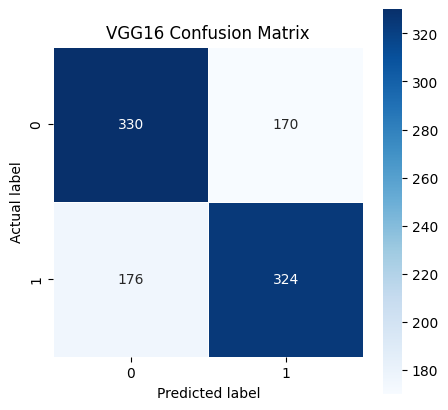

In [13]:
!pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('VGG16 Confusion Matrix')

# Define the file path where you want to save the confusion matrix plot
save_dir = "/kaggle/working/"
file_name = "confusion_matrix_before_ft.png"

# Save the plot with high resolution (dpi)
plt.savefig(save_dir + file_name, dpi=300)  # Adjust dpi as needed

# Show the plot if you want to display it
plt.show()


In [7]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    # Load the base ResNet152v2 model
    base_model = keras.applications.VGG16(
        weights="imagenet",
        input_shape=(256, 256, 3),
        include_top=False,
    )

    # Unfreeze the base_model layers
    base_model.trainable = True  # Set to True to fine-tune

    # Create new model on top
    inputs = keras.Input(shape=(256, 256, 3))

    # ResNet152V2 expects pixel values to be in the range [0, 255], so no need for additional rescaling.
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    # Set a very low learning rate (1e-5)
    custom_optimizer = keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(
        optimizer=custom_optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    model.summary()


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________

In [8]:
epochs = 300
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/300


2023-10-19 14:46:55.872806: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-10-19 14:46:56.025021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


282/282 [==============================] - ETA: 0s - loss: 0.4333 - binary_accuracy: 0.7643

2023-10-19 14:47:40.840818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-19 14:47:40.943771: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


282/282 [==============================] - 61s 137ms/step - loss: 0.4333 - binary_accuracy: 0.7643 - val_loss: 0.4326 - val_binary_accuracy: 0.8010
Epoch 2/300
282/282 [==============================] - 12s 41ms/step - loss: 0.3023 - binary_accuracy: 0.8401 - val_loss: 0.3375 - val_binary_accuracy: 0.8540
Epoch 3/300
282/282 [==============================] - 12s 41ms/step - loss: 0.2432 - binary_accuracy: 0.8786 - val_loss: 0.2350 - val_binary_accuracy: 0.9020
Epoch 4/300
282/282 [==============================] - 12s 42ms/step - loss: 0.1979 - binary_accuracy: 0.8988 - val_loss: 0.2291 - val_binary_accuracy: 0.9080
Epoch 5/300
282/282 [==============================] - 12s 41ms/step - loss: 0.1741 - binary_accuracy: 0.9158 - val_loss: 0.1952 - val_binary_accuracy: 0.9220
Epoch 6/300
282/282 [==============================] - 12s 41ms/step - loss: 0.1596 - binary_accuracy: 0.9238 - val_loss: 0.2052 - val_binary_accuracy: 0.9180
Epoch 7/300
282/282 [==============================] - 12

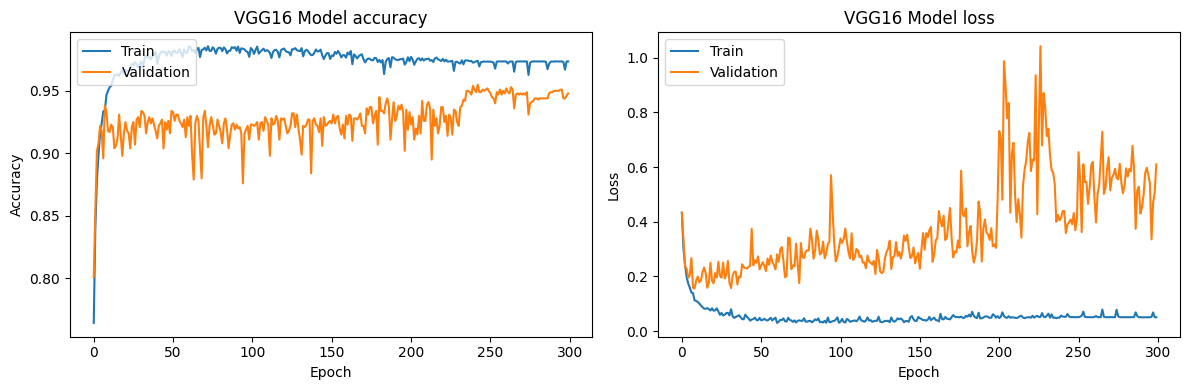

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('VGG16 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

# Define the file path where you want to save the plot
save_dir = "/kaggle/working/"
file_name = "training_plot_after_ft.png"

# Save the plot with high resolution (dpi)
plt.savefig(save_dir + file_name, dpi=300)  # Adjust dpi as needed

# Show the plot if you want to display it
plt.show()


After 10 epochs, fine-tuning gains us a nice improvement here.

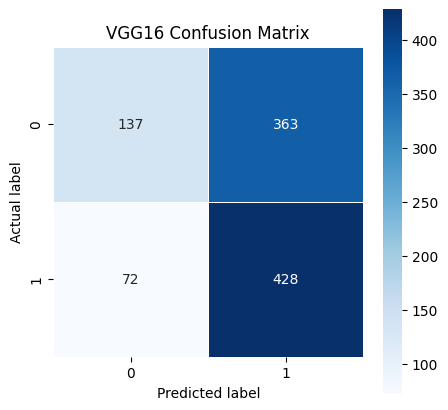

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('VGG16 Confusion Matrix')

# Define the file path where you want to save the confusion matrix plot
save_dir = "/kaggle/working/"
file_name = "confusion_matrix_after_ft.png"

# Save the plot with high resolution (dpi)
plt.savefig(save_dir + file_name, dpi=300)  # Adjust dpi as needed

# Show the plot if you want to display it
plt.show()
